In [1]:
%matplotlib inline

import numpy as np 
import pandas
import matplotlib.pyplot as plt
from scipy.io import loadmat


In [82]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')
X = data['X']
y = data['y']
print(X.shape, y.shape)

(5000, 400) (5000, 1)


# 1 Neural Networks

3


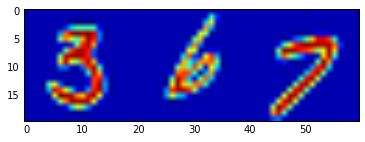

In [3]:
plt.imshow(np.reshape(np.append(X[1999], [X[3100], X[3600]]), (60,20)).T)
print(y[1999][0])

In [4]:
# grab out the weights
theta1 = weights['Theta1']
theta2 = weights['Theta2']
print (theta1.shape, theta2.shape)

(25, 401) (10, 26)


## 1.3 Feedforward and cost function

In [5]:
# Remap y output layers to one-hot vectors
yVec = np.ndarray((y.shape[0], 10))
for i, v in enumerate(y):
    val = v[0]
    yVec[i] = np.zeros(10)
    yVec[i][val-1] = 1

print(yVec[1], y[1])
    

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.] [10]


In [19]:
# Feedforward 
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def predict(X, t1, t2):
    """Given a matrix of inputs X and two weight matrices t1 and t2,
    computes the output one-hot vectors, yielded by t2(t1(x))
    
    actually returns intermediate stuff, so z1, a1, z2, a2"""
    m = X.shape[0] # num of training examples
    # insert col of 1s at front, one for each training example
    X = np.insert(X, 0, values=np.ones(m), axis=1) 
    # now multiply X * t1.T, (m, 401) x (401, 25) = (m, 25)
    z2 = np.dot(X, t1.T)
    # now slam it thru activation function
    a2 = sigmoid(z2)
    # now add in another col of bias units
    a2 = np.insert(a2, 0, values=np.ones(m), axis=1)
    # now multiply a1 * t2.T, (m, 26) x (26, 10) = (m, 10)
    z3 = np.dot(a2, t2.T)
    # now slam into sigmoid function to get actual vals
    a3 = sigmoid(z3)
    return z2, a2, z3, a3 
    
predict(X, theta1, theta2)[3]

array([[  1.12661530e-04,   1.74127856e-03,   2.52696959e-03, ...,
          4.01468105e-04,   6.48072305e-03,   9.95734012e-01],
       [  4.79026796e-04,   2.41495958e-03,   3.44755685e-03, ...,
          2.39107046e-03,   1.97025086e-03,   9.95696931e-01],
       [  8.85702310e-05,   3.24266731e-03,   2.55419797e-02, ...,
          6.22892325e-02,   5.49803551e-03,   9.28008397e-01],
       ..., 
       [  5.17641791e-02,   3.81715020e-03,   2.96297510e-02, ...,
          2.15667361e-03,   6.49826950e-01,   2.42384687e-05],
       [  8.30631310e-04,   6.22003774e-04,   3.14518512e-04, ...,
          1.19366192e-02,   9.71410499e-01,   2.06173648e-04],
       [  4.81465717e-05,   4.58821829e-04,   2.15146201e-05, ...,
          5.73434571e-03,   6.96288990e-01,   8.18576980e-02]])

In [83]:
# Cost function

def cost(X, y, t1, t2, lamb=1):
    """Given a set of training examples and labels, two weight matrices,
    and a learning rate, computes the value of the regularized cost function"""
    m = X.shape[0]
    J = 0 # cost
    # now let's compute the predictions for our weights
    h = predict(X, t1, t2)[3] # the output layer vals are the thirdelement in tuple
    
    # for every training example in X
    for i in range(m):
        # sum up the cost
#         print('**************')
#         print(-y[i])
#         print(h[i])
#         print(np.log(h[i]))
#         print(-y[i] * np.log(h[i]))
#         print(np.sum(-y[i] * np.log(h[i])))
#         print('-------------')
#         print(1-y[i])
#         print(h[i])
#         print(np.log(1 - h[i]))
#         print((1-y[i]) * np.log(1-h[i]))
#         print(np.sum((1-y[i]) * np.log(1-h[i])))
        J += np.sum(-y[i] * np.log(h[i]) - (1 - y[i]) * np.log(1 - h[i]))
        
    # add regularization
    # element-wise multiplication allows for squaring each entry
    # make sure to chop off the first column for the bias unit
    reg = lamb / (2*m) * (np.sum(t1[:,1:]*t1[:,1:]) 
                          + np.sum(t2[:,1:]*t2[:,1:]))
    
    return J * (1/m) + reg # don't forget to normalize for # of training examples

print(cost(X, yVec, theta1, theta2, 1)) # MAKE SURE TO PASS IN THE 1-HOT VEC

0.383769859091


# 2 Backpropagation

## 2.1 Sigmoid Gradient

In [8]:
def sigmoid_grad(z):
    return sigmoid(z) * (1 - sigmoid(z))

## 2.2 Random initialization

In [9]:
import random 

def init_rand_weights(in_size, out_size, epsilon=0.12):
    """Initializes weight matrix for an input layer of 
    size in_size and output layer of size out_size. 
    Matrix is of dimension (out_size, in_size + 1)
    input vectors are of dimension in_size + 1 with 
    bias units."""
    # scale
    return np.random.rand(out_size, in_size + 1) * 2 * epsilon - epsilon

## 2.3 Backpropagation


In [78]:
def backprop(X, y, t1, t2, lamb=1):
    """Runs the backpropagation algorithm on a given set of features
    and labels (10-vecs), returning gradients with respect to each weight
    (weight layers)."""
    m = len(X)
    # predict all vectors of labels
    z2, a2, z3, a3  = predict(X, t1, t2)
    # compute errors- element-wise subtraction
    delta_3 = a3 - y 
    # compute derivative, np.dot is the "derivative inside"?
    delta_2 = np.dot(delta_3, t2)[:,1:] * sigmoid_grad(z2)
    # accumulate gradients here
    # insert col of 1s at front, one for each training example (bias units needed)
    X = np.insert(X, 0, values=np.ones(m), axis=1) 
    D1, D2 = np.zeros_like(t1), np.zeros_like(t2)
    for d, a in zip(delta_3, a2):
        D2 += np.outer(d,a)
    for d, a in zip(delta_2, X):
        D1 += np.outer(d,a)
    # regularization
    reg1 = t1[:,1:] * lamb / m
    reg2 = t2[:,1:] * lamb / m
    # insert zeros at front so we can add it
    reg1 = np.insert(reg1, 0, values=np.zeros(t1.shape[0]), axis=1)
    reg2 = np.insert(reg2, 0, values=np.zeros(t2.shape[0]), axis=1)
    return D1 / m + reg1, D2 / m + reg2
        
backprop(X, yVec, theta1, theta2)

(array([[  6.18712766e-05,  -2.11248326e-12,   4.38829369e-13, ...,
           7.09042553e-09,   1.84706139e-09,   5.60928898e-13],
        [  9.38798109e-05,   1.53233736e-12,  -1.95174738e-12, ...,
           2.10747891e-08,  -8.61281252e-11,   7.08845709e-13],
        [ -1.92593606e-04,  -1.75530893e-12,   1.63207553e-12, ...,
           4.63501184e-08,   9.48509834e-10,  -1.50133620e-12],
        ..., 
        [  6.60569302e-05,  -1.77854412e-12,  -1.96393620e-12, ...,
          -9.34100149e-09,   1.29689159e-09,   1.80499812e-12],
        [  2.90522062e-04,   6.10356747e-14,   5.12122016e-13, ...,
           3.33797620e-07,  -3.66032512e-08,   7.67523996e-13],
        [ -6.33753316e-05,   1.77175372e-12,  -1.31503028e-13, ...,
           4.69418663e-09,   2.83929031e-09,   1.75890906e-12]]),
 array([[  6.28737643e-04,   5.08457277e-04,   7.84221985e-05,
           1.01449847e-03,   5.20245821e-04,   9.39490340e-04,
          -4.65577532e-05,  -4.26660299e-04,  -8.07731636e-04,
   

## 2.6 Learning parameters using `scipy.optimize.minimize`
- Optimization function takes a parameter vector to pass into a function, so we need to modify our approach
    - Create wrapper that takes unrolled vector, wraps and returns cost and gradient perhaps?
    - From SciPy's [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), we can either set argument `jacobian` to True (and have the function return the unrolled backprop results as well) or specify a function 
    - Will make two wrapper functions
        - Wrapper for cost takes params, rolls, and computes scalar cost
        - Wrapper for backprop takes params, rolls, computes backprop, and unrolls delta matrices
    - Worth fixing- hardcoded the shapes of the layers...

In [116]:
def cost_wrap(params, X, y, lamb=1):
    t1 = np.reshape(params[:25*401],(25,401))
    t2 = np.reshape(params[25*401:],(10,26))
    return cost(X, y, t1, t2, lamb)

cost_wrap(a, X, yVec)

0.38376985909092354

In [124]:
def backprop_wrap(params, X, y, lamb=1):
    t1 = np.reshape(params[:25*401],(25,401))
    t2 = np.reshape(params[25*401:],(10,26))
    D1, D2 = backprop(X, y, t1, t2, lamb)
    return np.concatenate((np.reshape(D1, -1), np.reshape(D2, -1)))

backprop_wrap(a, X, yVec)

array([  6.18712766e-05,  -2.11248326e-12,   4.38829369e-13, ...,
         4.70513145e-05,  -5.01718610e-04,   5.07825789e-04])

In [133]:
from scipy.optimize import minimize

params = np.concatenate((np.reshape(theta1, -1), np.reshape(theta2, -1)))
fmin = minimize(fun = cost_wrap, x0 = params, args = (X,y), 
               method='TNC', jac=backprop_wrap, options = {'maxiter':2})


In [136]:
fmin

     fun: -13751.779487415764
     jac: array([  2.07430506e+00,  -2.11248326e-12,   4.38829369e-13, ...,
        -4.42005424e+00,  -3.13696624e+00,  -1.48499135e+00])
 message: 'Max. number of function evaluations reached'
    nfev: 2
     nit: 0
  status: 3
 success: False
       x: array([ -2.25623899e-02,  -1.05624163e-08,   2.19414684e-09, ...,
        -2.47795788e-01,   1.28009118e+00,  -1.32752042e+00])

In [138]:
cost_wrap(fmin.x, X, yVec)

0.38376985909092354

In [191]:
p = params
epoch = []
for i in range(1000):
    f_cost = cost_wrap(p, X, yVec)
    epoch.append(f_cost)
    bp = backprop_wrap(p, X, yVec)
    p = p - 2 * bp

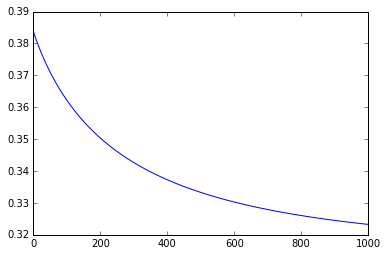

In [192]:
plt.plot(epoch)

In [193]:
# trained parameters
p
y[0], yVec[0]

(array([10], dtype=uint8),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]))

In [194]:
p1 = np.reshape(p[:25*401],(25,401))
p2 = np.reshape(p[25*401:],(10,26))
new_confidences = predict(X, p1, p2)
trained_predictions = np.around(new_confidences[3])

# np.equal(trained_predictions, yVec)

sum(np.argmax(trained_predictions, axis=1) + 1 == y.flatten()).astype(int)/5000

0.97440000000000004